<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/2%EA%B0%95/Transformer_MHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습

[MYCODE] 심화과제

- 기본과제를 기반으로 심화과제를 진행
- MHA, Norm, Dropout 등을 학습하기 위하여 데이터 셋을 이용하여 학습

In [ ]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


[MYCODE] collate_fn

- device 쿠다로 변경
  - 맥 환경에서 사용시 mps 쉽게 변경하기 한 변수 선언
  



```python
print(f"collate_fn label = {label}")
print(f"collate_fn label = {text}")
print(f"row={row}")
```



In [ ]:
device = 'cuda'

In [ ]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from torch.nn.utils.rnn import pad_sequence
torch.set_printoptions(threshold=torch.inf)
from torch import nn
from math import sqrt

ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')

def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    row = row['text']

    token = tokenizer(row, truncation=True, max_length=max_len)
    label = token.input_ids[-2]
    text  = torch.LongTensor(token.input_ids[:-2])

    labels.append(label)
    texts.append(text)

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

train_loader = DataLoader(
    ds['train'], batch_size=4, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=4, shuffle=False, collate_fn=collate_fn
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[MYCODE] 하나의 데이터만 확인해보기
 - 확인하기 위한 데이터 2개를 가져와서 데이터로더 생성

In [ ]:
valid_loader = DataLoader(
    ds['test'].select(range(2)), batch_size=2, shuffle=False, collate_fn=collate_fn
)

[MYCODE] valid_loader로 값 Shape 확인



In [ ]:
batch = next(iter(valid_loader))
if isinstance(batch, tuple) and len(batch) == 2:
    texts, labels = batch
    print("Texts shape:", texts.shape)  # 예상: (batch_size, seq_len)
    print("Labels shape:", labels.shape)  # 예상: (batch_size,
    print("Sample labels:", labels)  # 첫 2개 라벨 샘플
    print(f"Text = {texts}")

    # CLS
    print(f"{tokenizer.decode(texts[0][0])}")

else:
    print("Unexpected batch format:", batch)


Texts shape: torch.Size([2, 337])
Labels shape: torch.Size([2])
Sample labels: tensor([1012, 1012])
Text = tensor([[  101,  1045,  2293, 16596,  1011, 10882,  1998,  2572,  5627,  2000,
          2404,  2039,  2007,  1037,  2843,  1012, 16596,  1011, 10882,  5691,
          1013,  2694,  2024,  2788,  2104, 11263, 25848,  1010,  2104,  1011,
         12315,  1998, 28947,  1012,  1045,  2699,  2000,  2066,  2023,  1010,
          1045,  2428,  2106,  1010,  2021,  2009,  2003,  2000,  2204,  2694,
         16596,  1011, 10882,  2004, 17690,  1019,  2003,  2000,  2732, 10313,
          1006,  1996,  2434,  1007,  1012, 10021,  4013,  3367, 20086,  2015,
          1010, 10036, 19747,  4520,  1010, 25931,  3064, 22580,  1010,  1039,
          2290,  2008,  2987,  1005,  1056,  2674,  1996,  4281,  1010,  1998,
         16267,  2028,  1011,  8789,  3494,  3685,  2022,  9462,  2007,  1037,
          1005, 16596,  1011, 10882,  1005,  4292,  1012,  1006,  1045,  1005,
          1049,  2469,  

[MYCODE] 워드 임베딩 값 확인

- 전체 텍스트 중 가장 큰 사이즈를 찾아 +1 처리해줍니다.
vocab_size 맞추기
- 디멘션 늘리기
d_model = 4


In [ ]:
text, label = batch
max_text_size = max(text.flatten().tolist()) + 1
vocab_size = max_text_size
d_model = 4
# 임베딩
embedding_layer = nn.Embedding(vocab_size, d_model)

layer = embedding_layer(text)
#print(layer[0])
print(layer[0,1])
print(layer[0,1,0])

tensor([-0.4295,  2.0183,  1.0725,  0.2609], grad_fn=<SelectBackward0>)
tensor(-0.4295, grad_fn=<SelectBackward0>)


[MYCODE] 어텐션 -> 멀티헤드로 수정

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, d_model, n_heads):
        """
        멀티 헤드 어텐션 레이어
        :param input_dim: 입력 특성의 차원
        :param d_model: 모델의 차원
        :param n_heads: 어텐션 헤드의 개수
        """
        super().__init__()
        assert d_model % n_heads == 0, "d_model은 n_heads로 나누어 떨어져야 합니다."

        self.n_heads = n_heads
        self.d_model = d_model
        self.head_dim = d_model // n_heads

        # Q, K, V를 위한 선형 레이어
        self.wq = nn.Linear(input_dim, d_model)
        self.wk = nn.Linear(input_dim, d_model)
        self.wv = nn.Linear(input_dim, d_model)

        # 출력 선형 레이어
        self.dense = nn.Linear(d_model, d_model)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        멀티 헤드 어텐션의 순전파 과정
        :param x: 입력 텐서의 크기 (B, S, input_dim)
        :param mask: 선택적 마스크 텐서, 크기 (B, 1, S, S)
        :return: 어텐션 출력 텐서, 크기 (B, S, d_model)
        """
        # print(f"입력 텐서 크기: {x.shape}")
        B, S, _ = x.shape

        # Q, K, V 생성
        q = self.wq(x)  # (B, S, d_model)
        k = self.wk(x)  # (B, S, d_model)
        v = self.wv(x)  # (B, S, d_model)

        # print(f"Q 텐서 크기: {q.shape}, K 텐서 크기: {k.shape}, V 텐서 크기: {v.shape}")

        # 다중 헤드로 변환 후 어텐션 계산을 위해 차원 변경
        q = q.view(B, S, self.n_heads, self.head_dim).transpose(1, 2)  # (B, H, S, D')
        k = k.view(B, S, self.n_heads, self.head_dim).transpose(1, 2)  # (B, H, S, D')
        v = v.view(B, S, self.n_heads, self.head_dim).transpose(1, 2)  # (B, H, S, D')

        #print(f"변환 후 Q 텐서 크기: {q.shape}, K 텐서 크기: {k.shape}, V 텐서 크기: {v.shape}")

        # 스케일 점곱 어텐션 계산
        score = torch.matmul(q, k.transpose(-1, -2)) / sqrt(self.head_dim)  # (B, H, S, S)
        #print(f"어텐션 점수 크기: {score.shape}")

        if mask is not None:
            score = score + (mask * -1e9)

        # 어텐션 점수에 소프트맥스 적용
        attention = self.softmax(score)  # (B, H, S, S)
        #print(f"어텐션 가중치 크기: {attention.shape}")

        x = torch.matmul(attention, v)  # (B, H, S, D')
        #print(f"가중합 결과 크기: {x.shape}")

        # 원래 크기 (B, S, d_model)로 다시 변환
        x = x.transpose(1, 2).contiguous().view(B, S, self.d_model)
        # print(f"최종 선형 적용 전 출력 크기: {x.shape}")

        # 최종 선형 레이어 적용
        x = self.dense(x)
        # print(f"최종 출력 크기: {x.shape}")

        return x

[MYCODE] Layer 정규화, GELU, Dropout 적용

In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, num_heads):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.MHA = MultiHeadAttention(input_dim, d_model, num_heads)
    self.FFN = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.GELU(),
      nn.Linear(dff, d_model)
    )

    self.Dropout = nn.Dropout(0.1)
    self.LayerNormalization1 = nn.LayerNorm(d_model)  # MHA 후 정규화
    self.LayerNormalization2 = nn.LayerNorm(d_model)  # FFN 후 정규화



  def forward(self, x, mask):
    x1 = self.MHA(x, mask)
    x1 = self.Dropout(x1)
    x1 = self.LayerNormalization1(x1 + x)

    x2 = self.FFN(x1)
    x2 = self.Dropout(x2)
    x2 = self.LayerNormalization2(x2 + x1)

    return x2

In [ ]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [ ]:
num_classes = len(set(ds['train']['label']))
print("Number of classes:", num_classes)

Number of classes: 2


[MYCODE] 클래스 분류 수치 조정하기

- vocab_size 로 최종 classification 값을 tokenizer로 만들기

[FEEDBACK]
- vocab_size가 tokenizer 사이즈 만큼 잡았는데 조금 학습해보니 토큰ID 중 가장 큰 값으로 설정해야 한다는 것을 알게되었는데 해당 무엇이 맞는지 잘 모르겠습니다.

In [ ]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, num_heads):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, num_heads) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 30522)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    return self.classification(x)


model = TextClassifier(len(tokenizer), 32, 5, 32, 4).to(device)
print(len(tokenizer))

30522


[MYCODE] 손실함수 변경

- 이진분류에서 클래스 분류 관련 손실함수로 변경 한다.

In [ ]:
from torch.optim import Adam

lr = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

[MYCODE] 실시간 정확도 그래프 보기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def live_plot(train_accs, test_accs, title="Real-time Accuracy", label1='train', label2='test'):
    # 플롯 크기 설정
    plt.figure(figsize=(10, 8))

    # 1번째 서브플롯: Train_loss vs test
    plt.subplot(2, 1, 1)
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label='train', color='blue')  # 훈련 손실
    plt.plot(x, test_accs, label='val', color='red', marker='o')  # 검증 손실
    plt.title("Train_loss vs Val_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()


    # 플롯 간격 조정 및 출력
    plt.tight_layout()
    plt.show()

In [ ]:
!pip install scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[MYCODE] 정확도 분리

-GPU 텐서에서 numpy 사용불가로 cpu 로 이동

In [ ]:
from sklearn.metrics import accuracy_score
def accuracy(model, dataloader):
    all_preds = []
    all_labels = []

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)

[MYCODE] 모델 학습

[LOG] 로그 남기기
- 로그를 train과 test plot(val) 로 그렸습니다.
  - test, val, train 각기 달리 만들어서 학습 해야하는 사실을 모델 학습이 끝난 후 알았습니다.
  - 아쉽게도 제출시간이 다가와서 다시 돌릴 시간이 없어서 val이 test 그래프임을 알아주세요

[FEEDBACK]
- 결국 오버피팅이 된 것 같습니다. 오버피팅된 부분을 해결하기 위해서 Dropout weight decay를 추후 적용해봐야할 것 같습니다.
-

100%|██████████| 6250/6250 [02:00<00:00, 51.69it/s]


Epoch   0 | Train Loss: 20543.85229885578


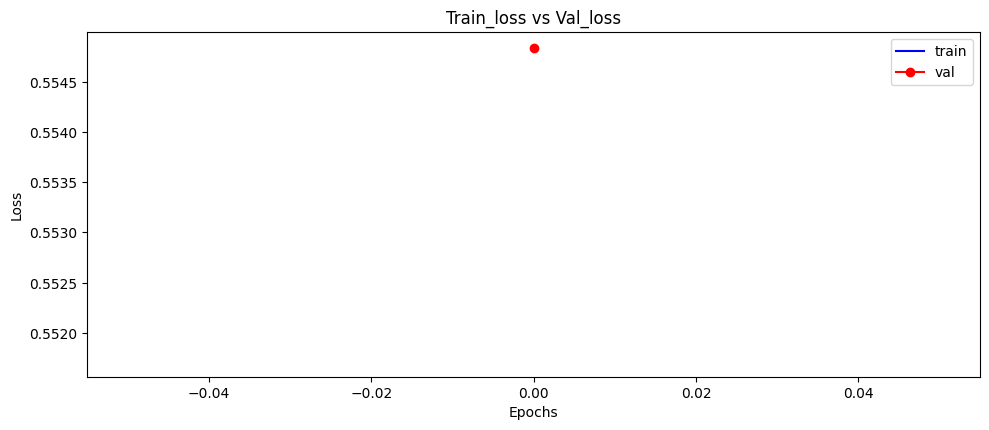

=========> Train acc: 0.552 | Test acc: 0.555


100%|██████████| 6250/6250 [01:57<00:00, 53.35it/s]


Epoch   1 | Train Loss: 17726.36214953661


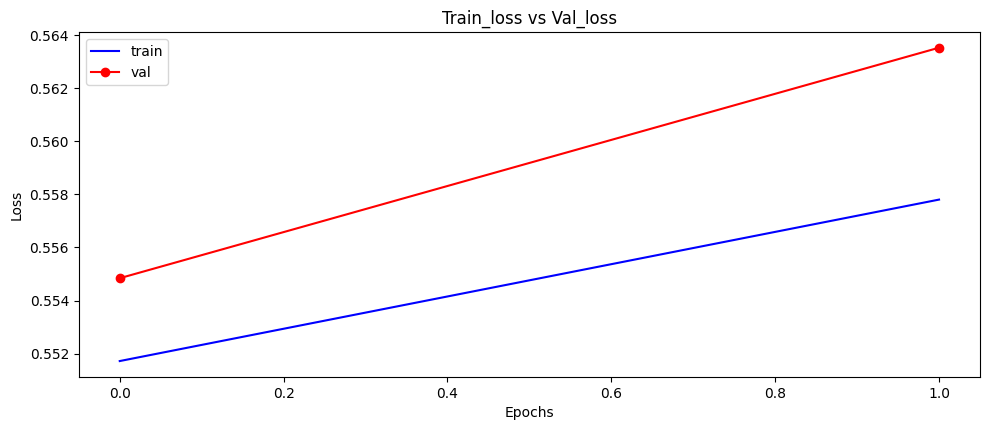

=========> Train acc: 0.558 | Test acc: 0.564


100%|██████████| 6250/6250 [01:57<00:00, 53.18it/s]


Epoch   2 | Train Loss: 17337.46879442036


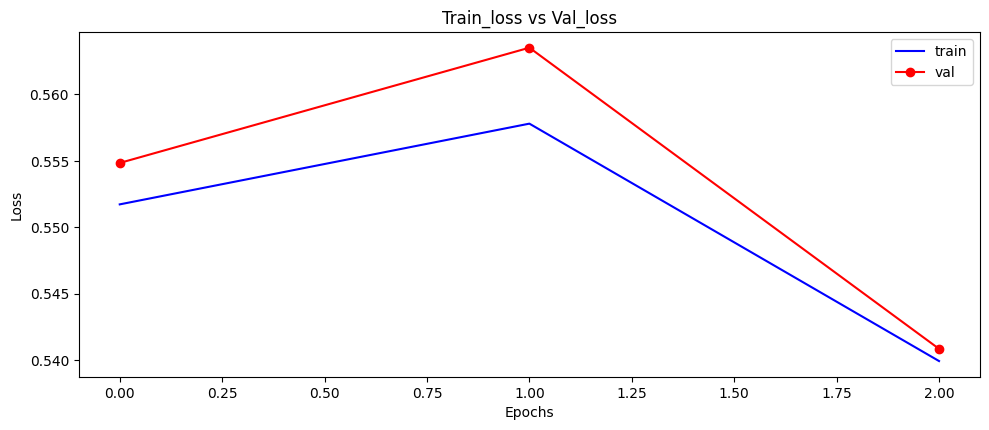

=========> Train acc: 0.540 | Test acc: 0.541


100%|██████████| 6250/6250 [01:59<00:00, 52.48it/s]


Epoch   3 | Train Loss: 17131.307259052992


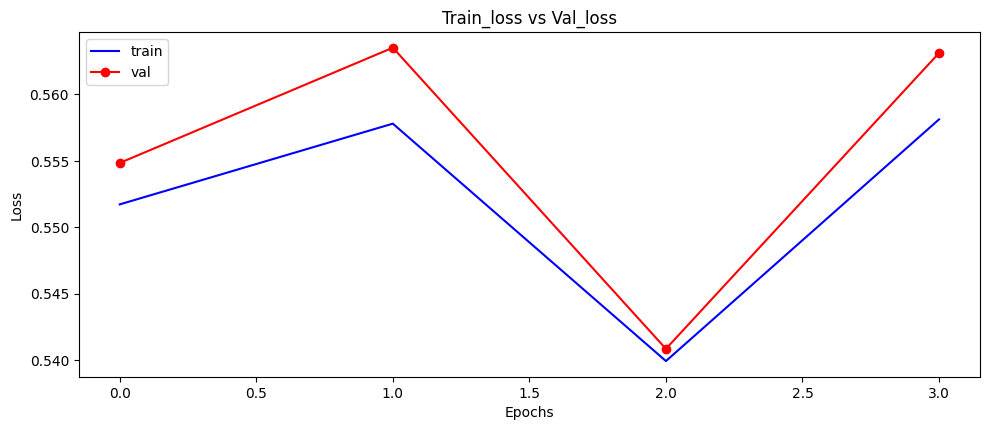

=========> Train acc: 0.558 | Test acc: 0.563


100%|██████████| 6250/6250 [01:58<00:00, 52.73it/s]


Epoch   4 | Train Loss: 16944.57444599271


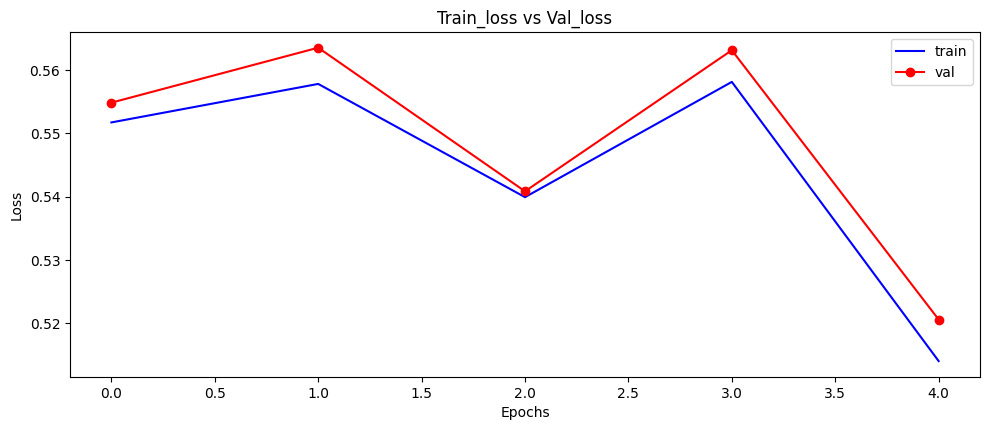

=========> Train acc: 0.514 | Test acc: 0.521


100%|██████████| 6250/6250 [01:58<00:00, 52.81it/s]


Epoch   5 | Train Loss: 16841.00289092958


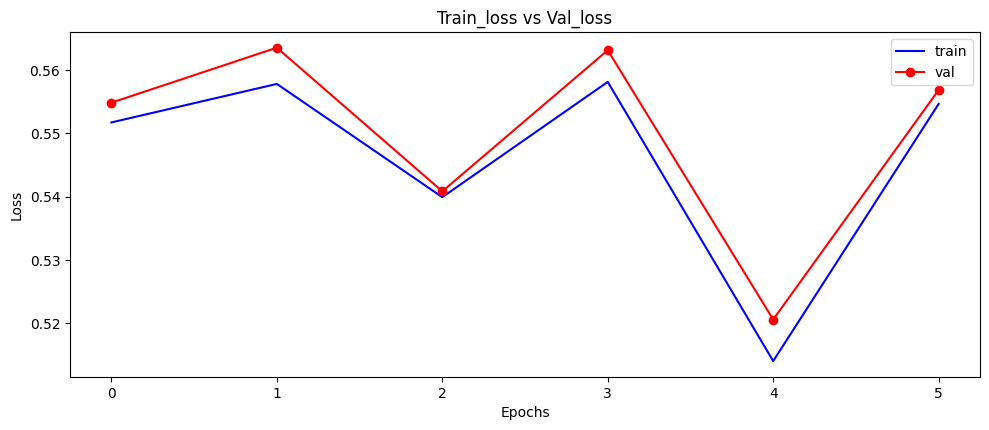

=========> Train acc: 0.555 | Test acc: 0.557


100%|██████████| 6250/6250 [01:59<00:00, 52.15it/s]


Epoch   6 | Train Loss: 16776.78381830454


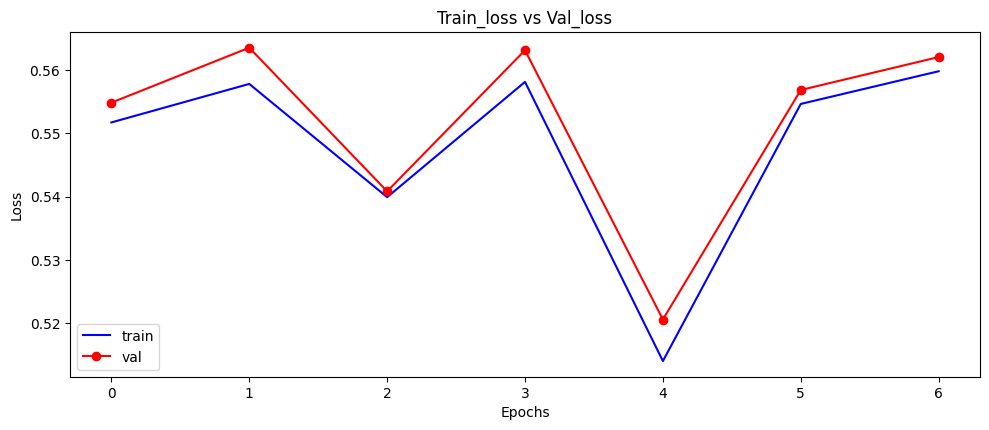

=========> Train acc: 0.560 | Test acc: 0.562


100%|██████████| 6250/6250 [01:59<00:00, 52.31it/s]


Epoch   7 | Train Loss: 16717.739049866796


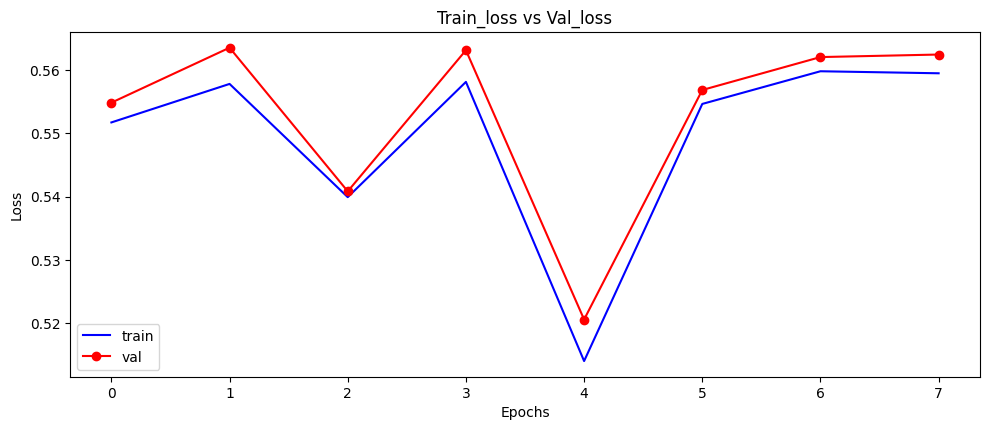

=========> Train acc: 0.559 | Test acc: 0.562


100%|██████████| 6250/6250 [02:01<00:00, 51.57it/s]


Epoch   8 | Train Loss: 16646.721380874515


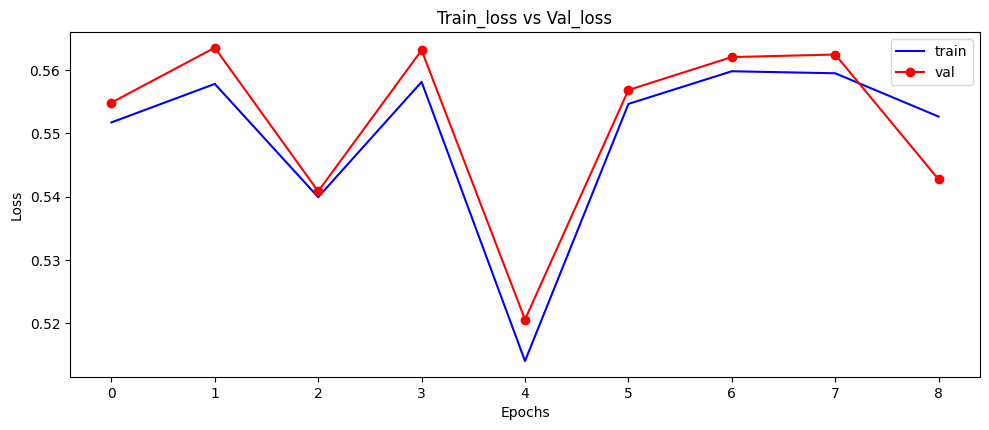

=========> Train acc: 0.553 | Test acc: 0.543


100%|██████████| 6250/6250 [02:01<00:00, 51.35it/s]


Epoch   9 | Train Loss: 16564.554209768772


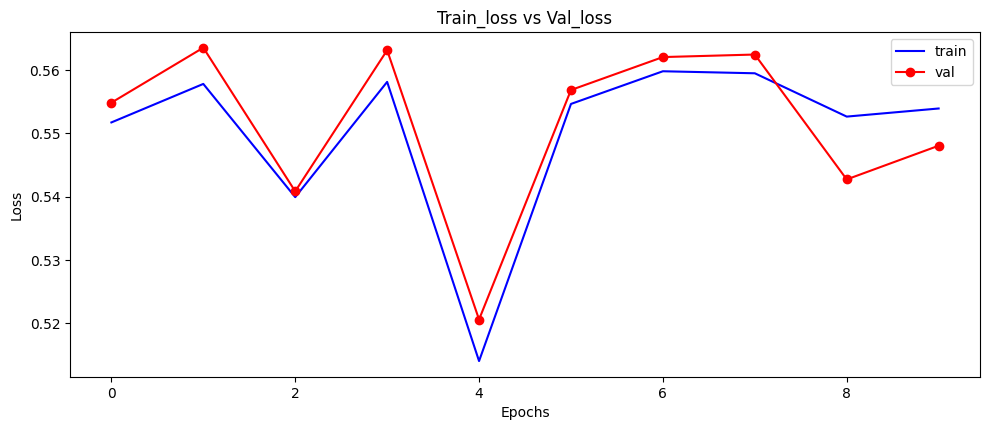

=========> Train acc: 0.554 | Test acc: 0.548


100%|██████████| 6250/6250 [02:01<00:00, 51.58it/s]


Epoch  10 | Train Loss: 16539.776964455843


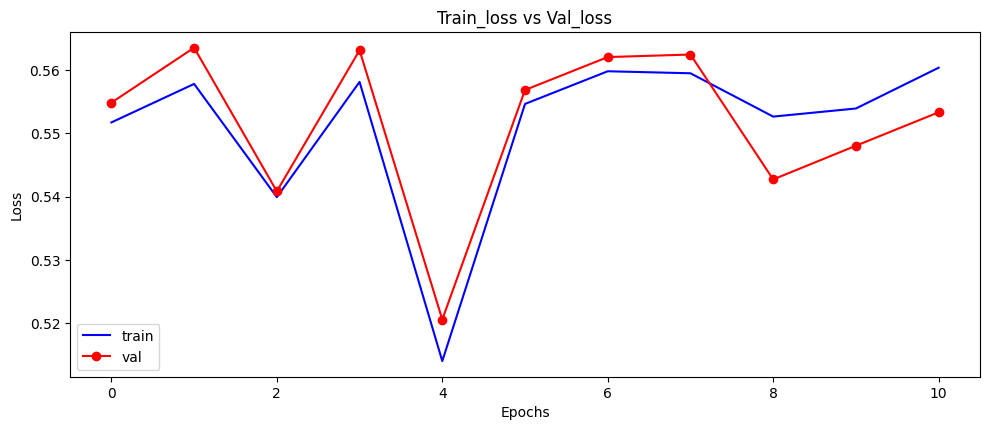

=========> Train acc: 0.560 | Test acc: 0.553


100%|██████████| 6250/6250 [02:00<00:00, 51.73it/s]


Epoch  11 | Train Loss: 16484.114359900355


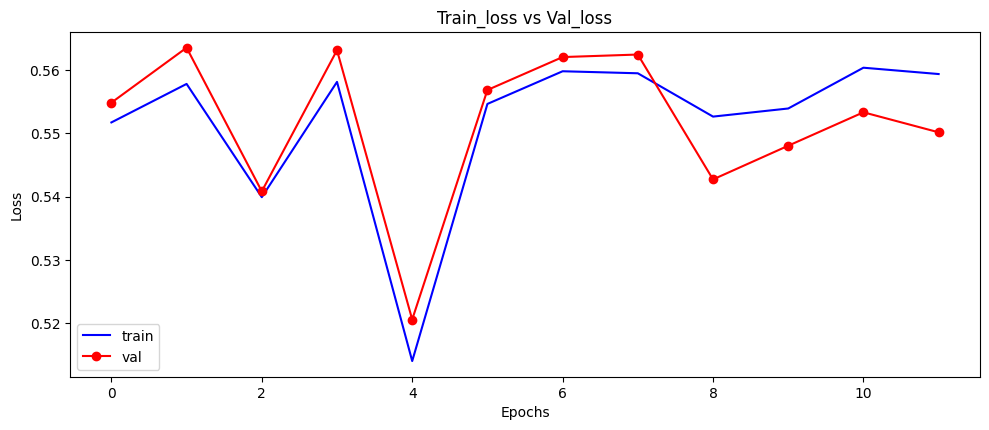

=========> Train acc: 0.559 | Test acc: 0.550


100%|██████████| 6250/6250 [02:01<00:00, 51.24it/s]


Epoch  12 | Train Loss: 16439.44239139557


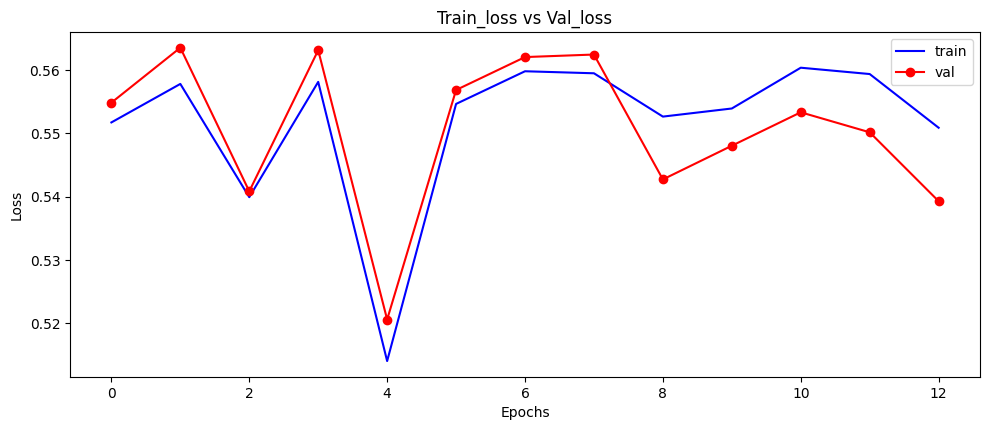

=========> Train acc: 0.551 | Test acc: 0.539


100%|██████████| 6250/6250 [02:02<00:00, 51.18it/s]


Epoch  13 | Train Loss: 16407.01588112116


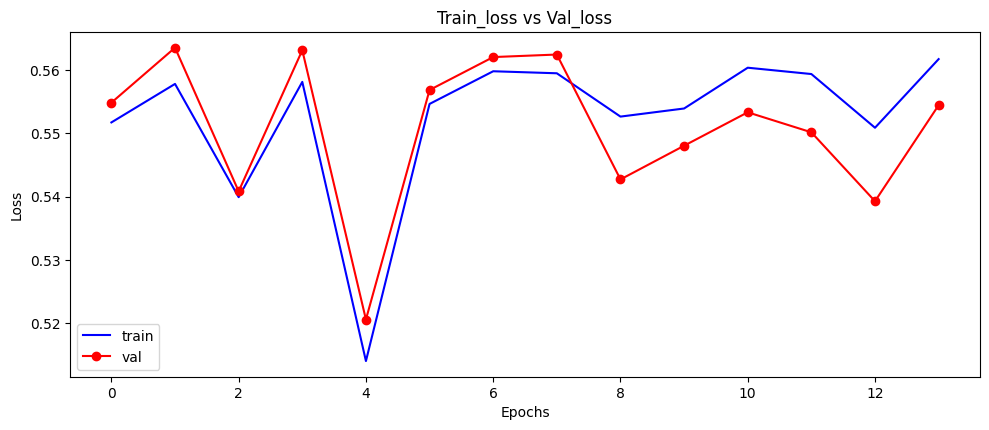

=========> Train acc: 0.562 | Test acc: 0.554


100%|██████████| 6250/6250 [02:04<00:00, 50.26it/s]


Epoch  14 | Train Loss: 16417.743592321873


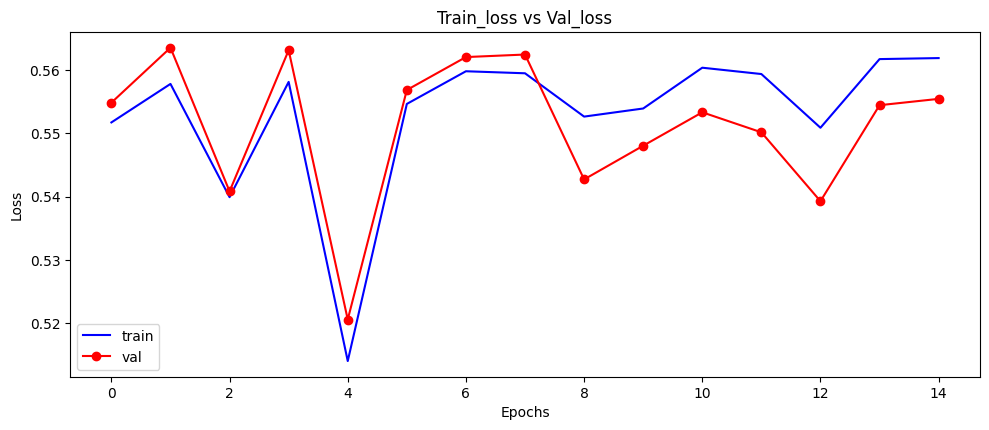

=========> Train acc: 0.562 | Test acc: 0.555


100%|██████████| 6250/6250 [02:03<00:00, 50.72it/s]


Epoch  15 | Train Loss: 16374.228505030274


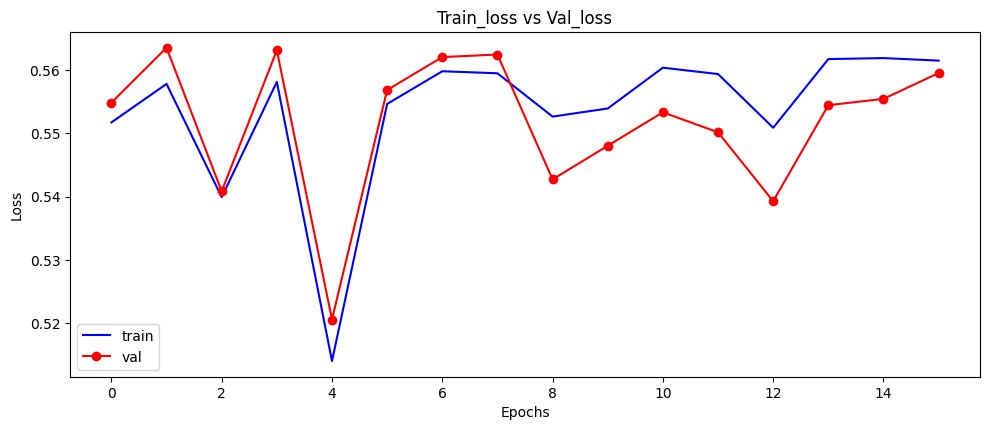

=========> Train acc: 0.561 | Test acc: 0.560


100%|██████████| 6250/6250 [02:03<00:00, 50.76it/s]


Epoch  16 | Train Loss: 16351.911623030901


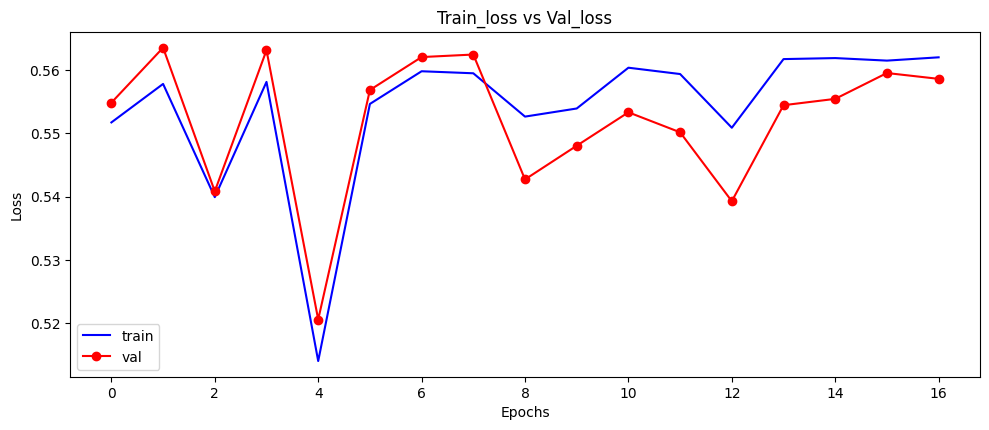

=========> Train acc: 0.562 | Test acc: 0.559


100%|██████████| 6250/6250 [02:02<00:00, 51.12it/s]


Epoch  17 | Train Loss: 16312.367309048772


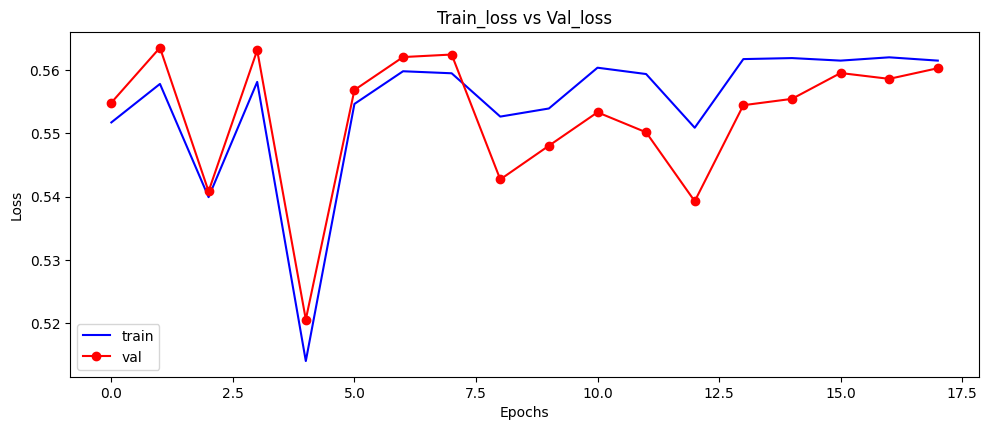

=========> Train acc: 0.561 | Test acc: 0.560


100%|██████████| 6250/6250 [02:03<00:00, 50.81it/s]


Epoch  18 | Train Loss: 16267.676610916853


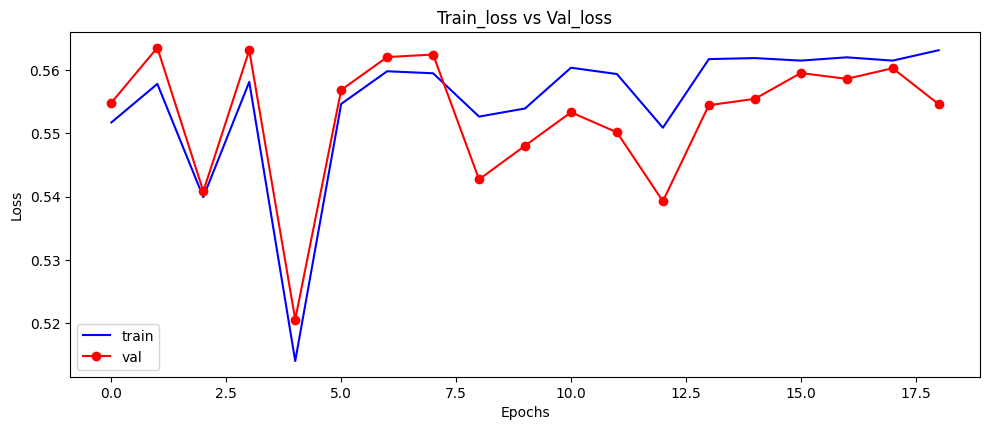

=========> Train acc: 0.563 | Test acc: 0.555


100%|██████████| 6250/6250 [02:02<00:00, 51.07it/s]


Epoch  19 | Train Loss: 16292.810029402375


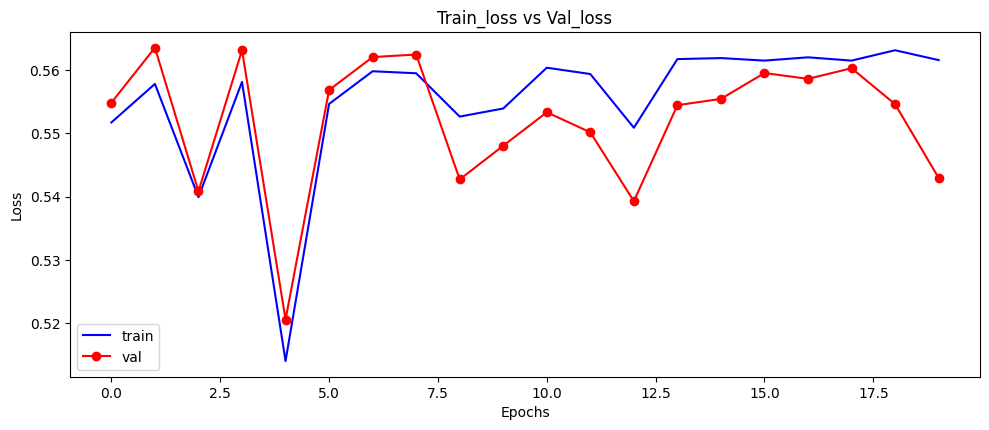

=========> Train acc: 0.562 | Test acc: 0.543


100%|██████████| 6250/6250 [02:02<00:00, 50.98it/s]


Epoch  20 | Train Loss: 16214.73065905273


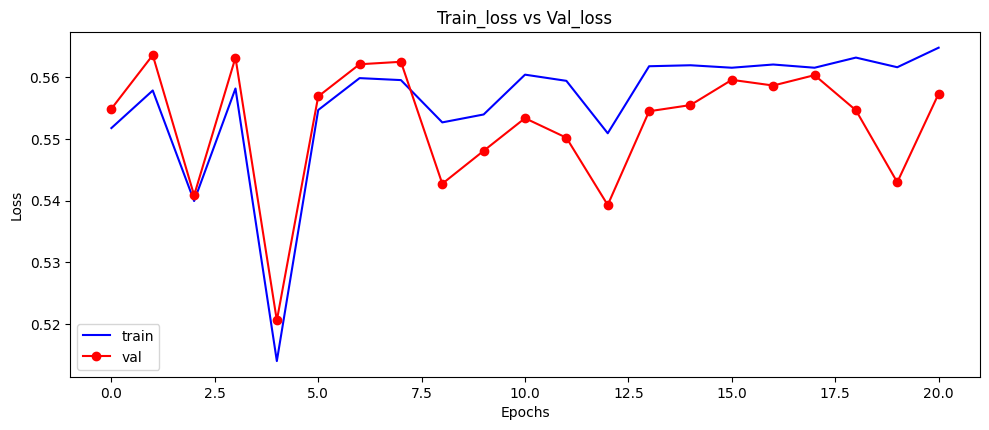

=========> Train acc: 0.565 | Test acc: 0.557


100%|██████████| 6250/6250 [02:02<00:00, 51.02it/s]


Epoch  21 | Train Loss: 16195.897325724363


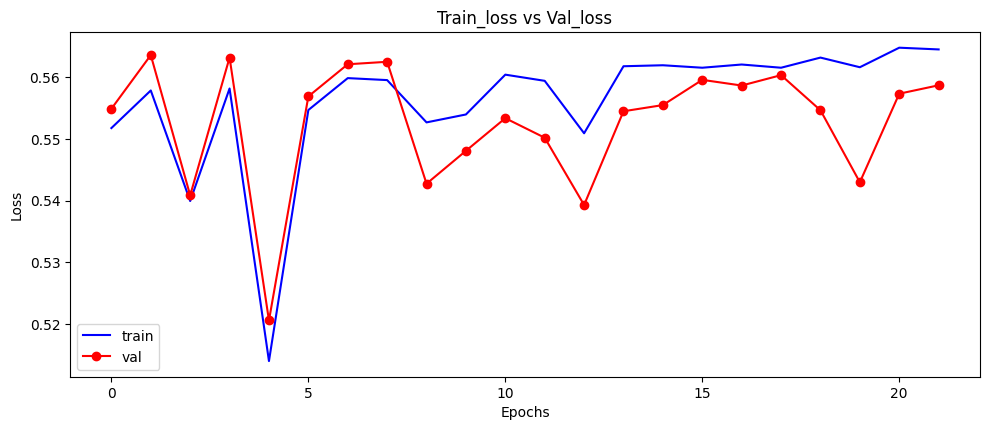

=========> Train acc: 0.564 | Test acc: 0.559


100%|██████████| 6250/6250 [02:02<00:00, 51.12it/s]


Epoch  22 | Train Loss: 16175.734912082553


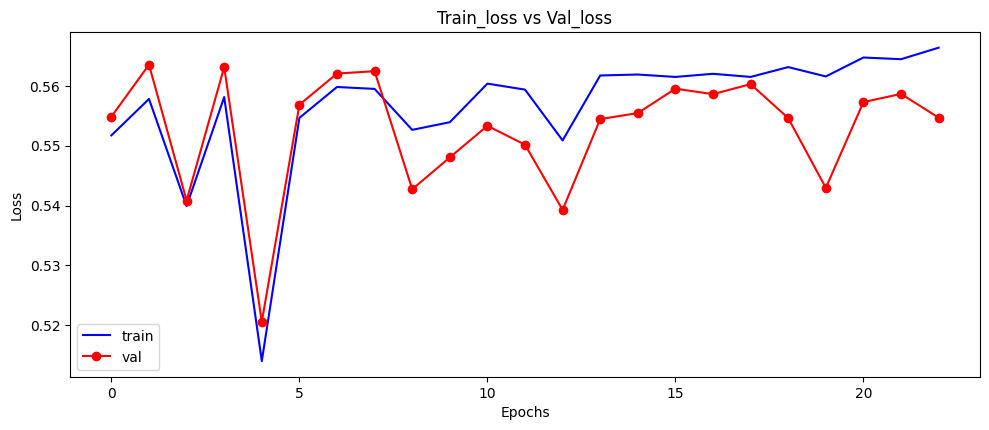

=========> Train acc: 0.566 | Test acc: 0.555


100%|██████████| 6250/6250 [02:02<00:00, 51.08it/s]


Epoch  23 | Train Loss: 16114.534727811813


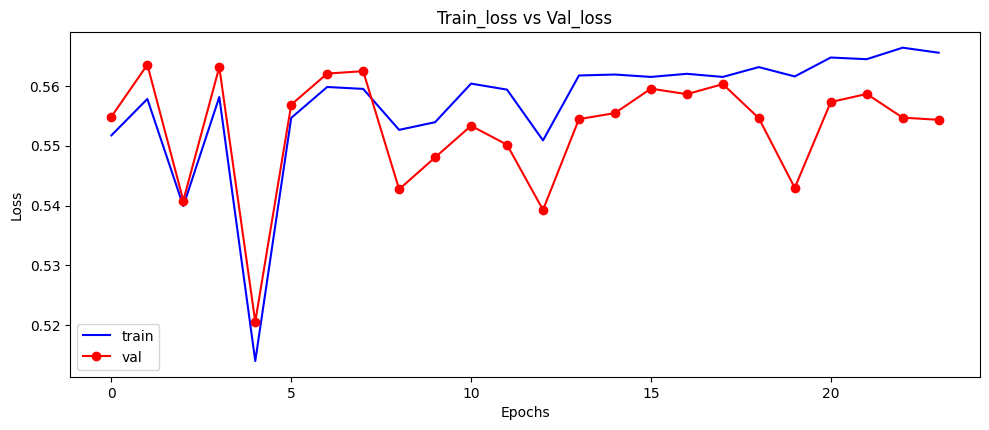

=========> Train acc: 0.566 | Test acc: 0.554


100%|██████████| 6250/6250 [02:03<00:00, 50.68it/s]


Epoch  24 | Train Loss: 16067.792654827237


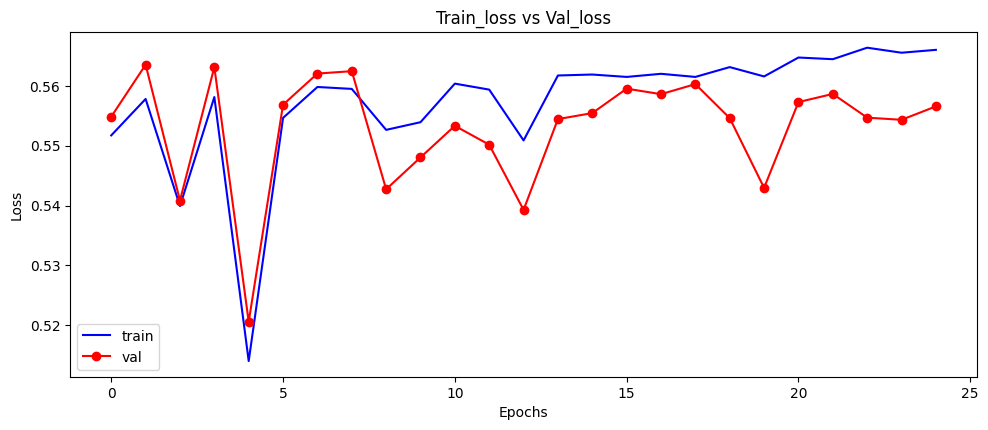

=========> Train acc: 0.566 | Test acc: 0.557


100%|██████████| 6250/6250 [02:04<00:00, 50.29it/s]


Epoch  25 | Train Loss: 16073.663458198309


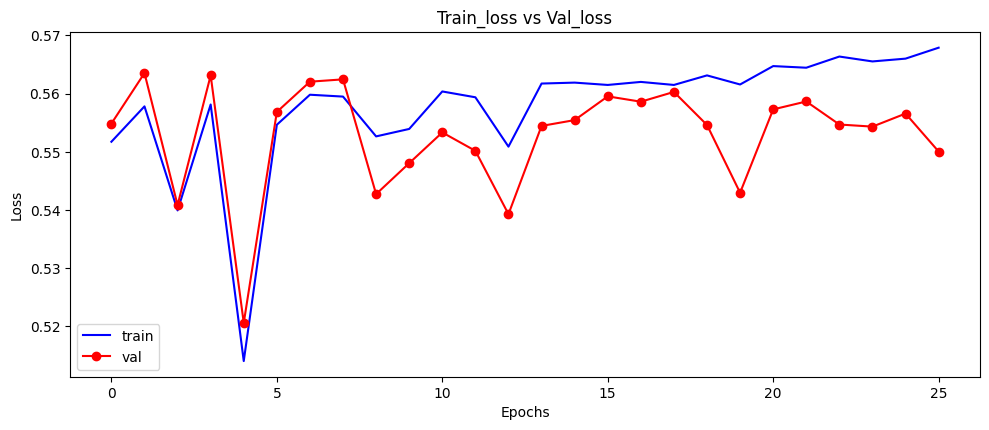

=========> Train acc: 0.568 | Test acc: 0.550


100%|██████████| 6250/6250 [02:04<00:00, 50.23it/s]


Epoch  26 | Train Loss: 15993.8065161407


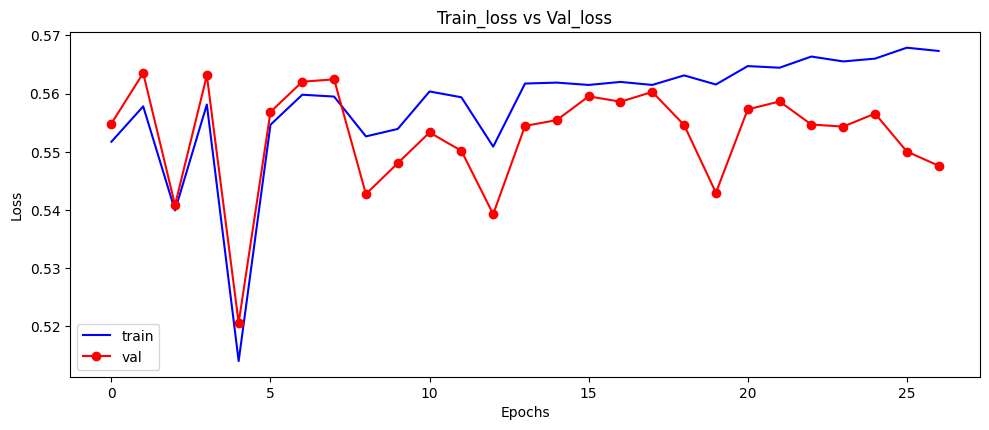

=========> Train acc: 0.567 | Test acc: 0.548


100%|██████████| 6250/6250 [02:05<00:00, 50.00it/s]


Epoch  27 | Train Loss: 15971.434785299003


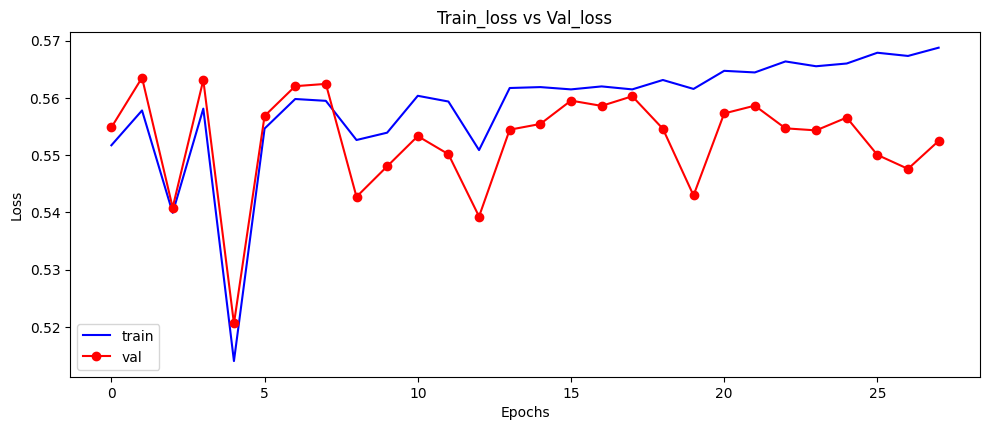

=========> Train acc: 0.569 | Test acc: 0.552


100%|██████████| 6250/6250 [02:04<00:00, 50.17it/s]


Epoch  28 | Train Loss: 15919.199965268373


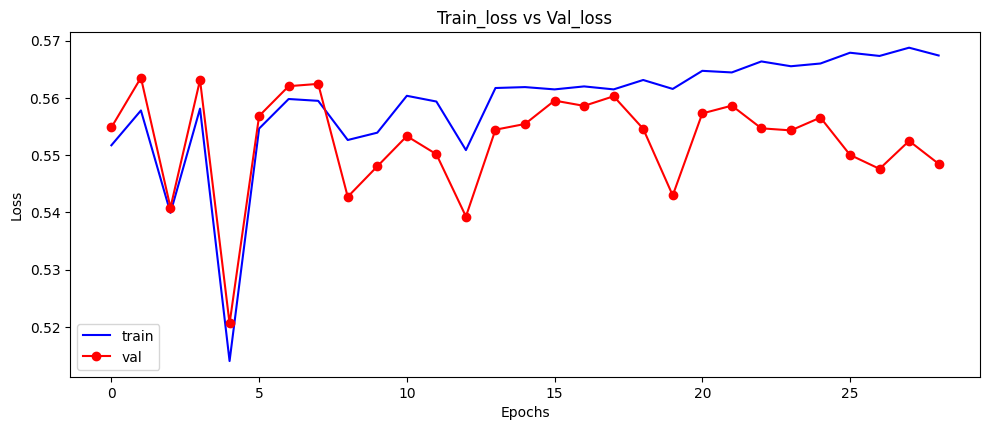

=========> Train acc: 0.567 | Test acc: 0.548


100%|██████████| 6250/6250 [02:05<00:00, 49.99it/s]


Epoch  29 | Train Loss: 15878.938102573156


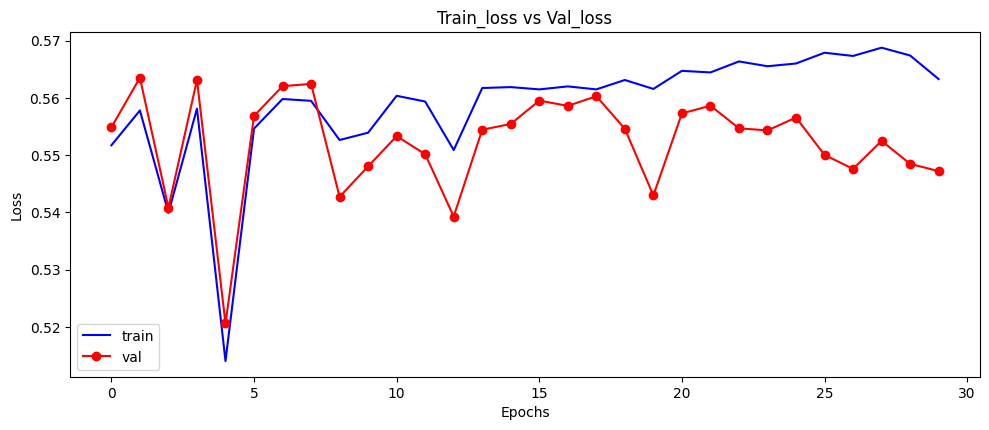

=========> Train acc: 0.563 | Test acc: 0.547


100%|██████████| 6250/6250 [02:05<00:00, 49.83it/s]


Epoch  30 | Train Loss: 15845.6930898875


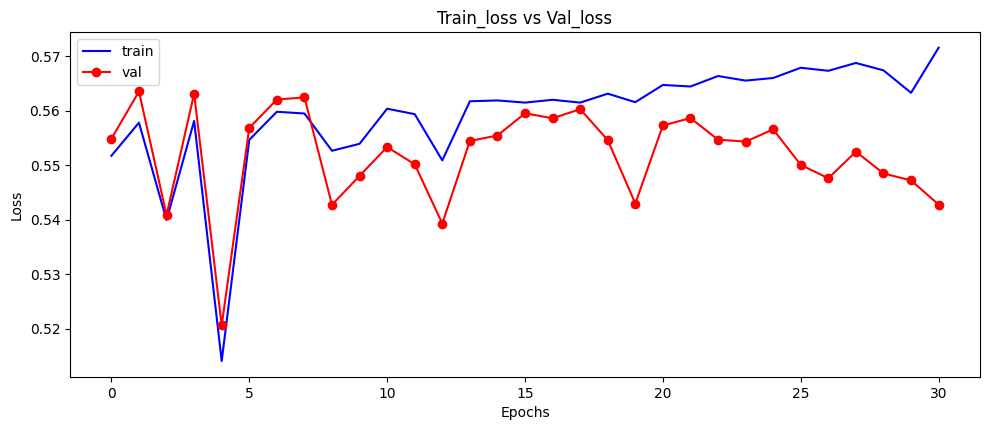

=========> Train acc: 0.572 | Test acc: 0.543


100%|██████████| 6250/6250 [02:07<00:00, 49.19it/s]


Epoch  31 | Train Loss: 15829.688767895103


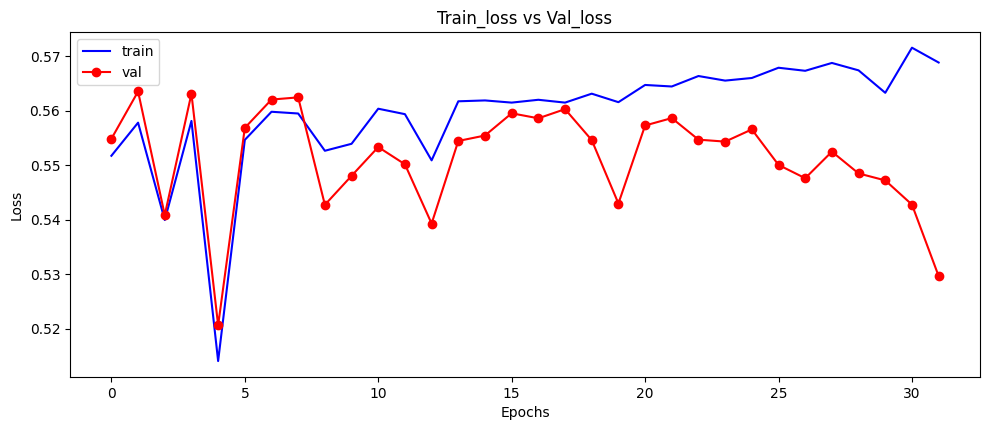

=========> Train acc: 0.569 | Test acc: 0.530


100%|██████████| 6250/6250 [02:05<00:00, 49.87it/s]


Epoch  32 | Train Loss: 15736.413137167692


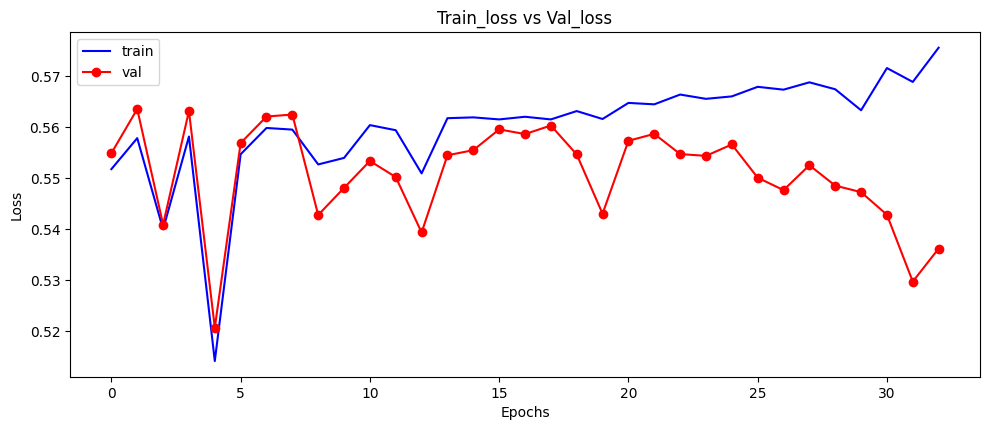

=========> Train acc: 0.576 | Test acc: 0.536


100%|██████████| 6250/6250 [02:05<00:00, 49.68it/s]


Epoch  33 | Train Loss: 15649.966536223888


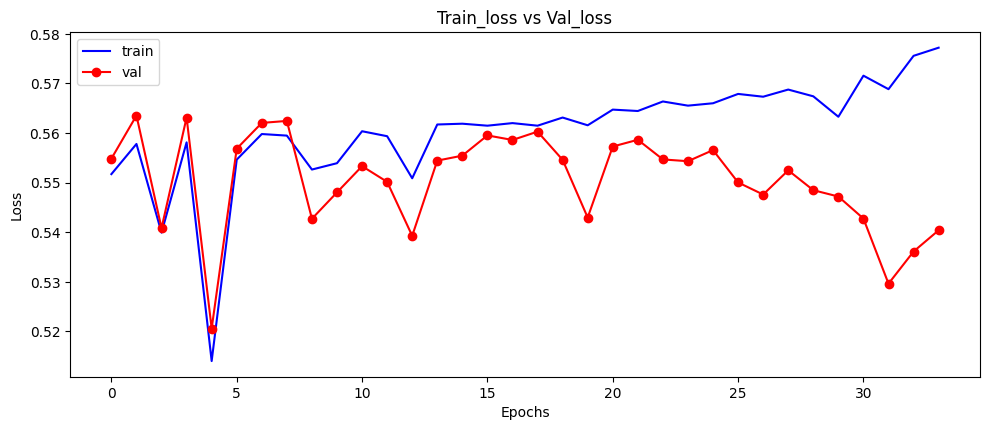

=========> Train acc: 0.577 | Test acc: 0.540


100%|██████████| 6250/6250 [02:06<00:00, 49.52it/s]


Epoch  34 | Train Loss: 15652.733108900487


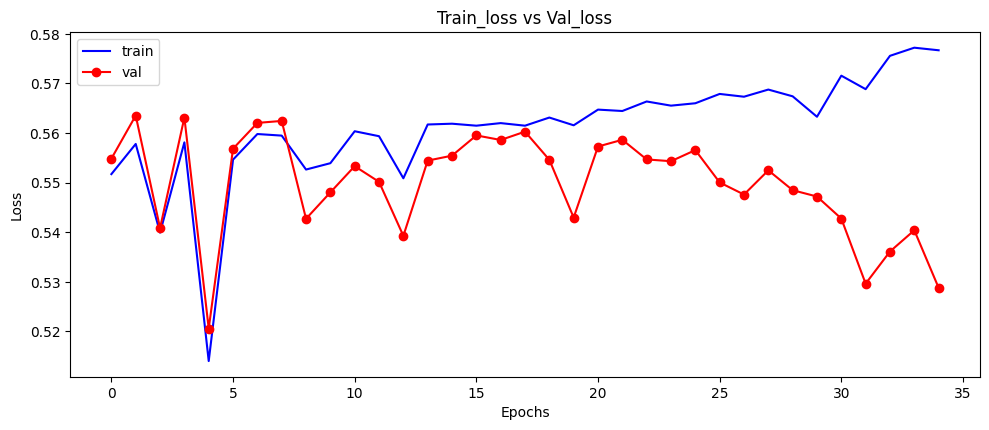

=========> Train acc: 0.577 | Test acc: 0.529


100%|██████████| 6250/6250 [02:06<00:00, 49.39it/s]


Epoch  35 | Train Loss: 15644.198606416583


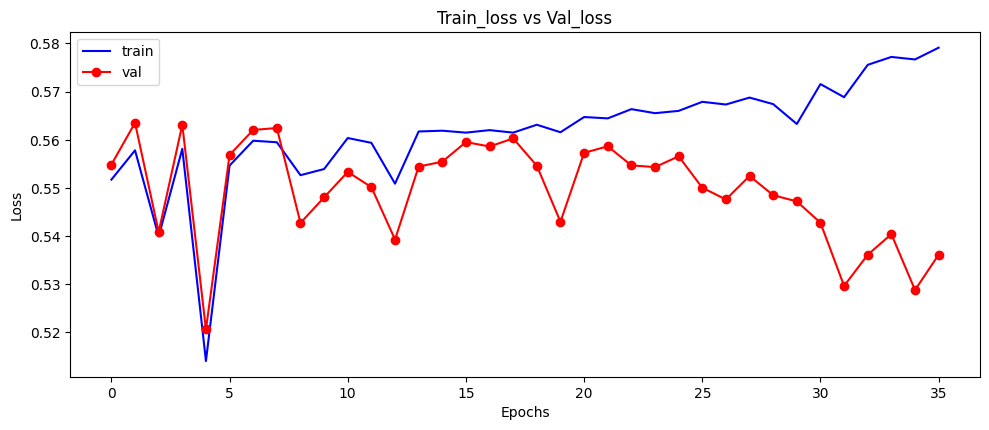

=========> Train acc: 0.579 | Test acc: 0.536


100%|██████████| 6250/6250 [02:06<00:00, 49.50it/s]


Epoch  36 | Train Loss: 15602.588619627059


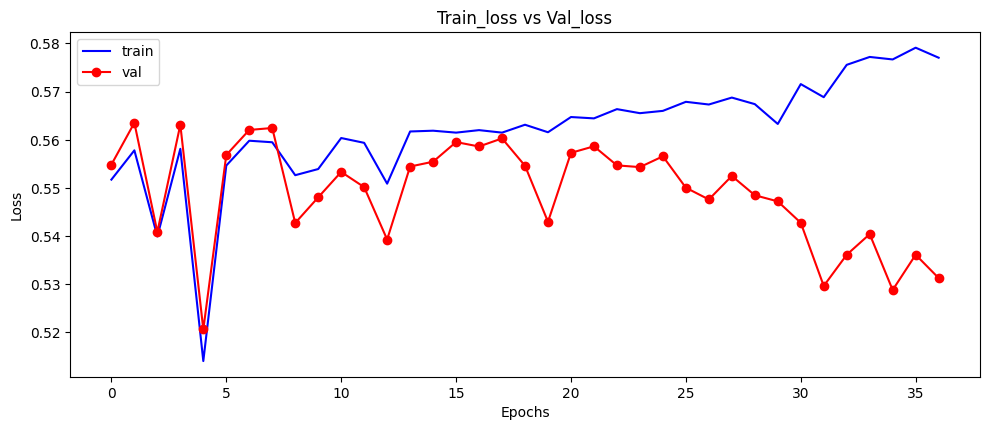

=========> Train acc: 0.577 | Test acc: 0.531


100%|██████████| 6250/6250 [02:07<00:00, 48.83it/s]


Epoch  37 | Train Loss: 15530.29615354538


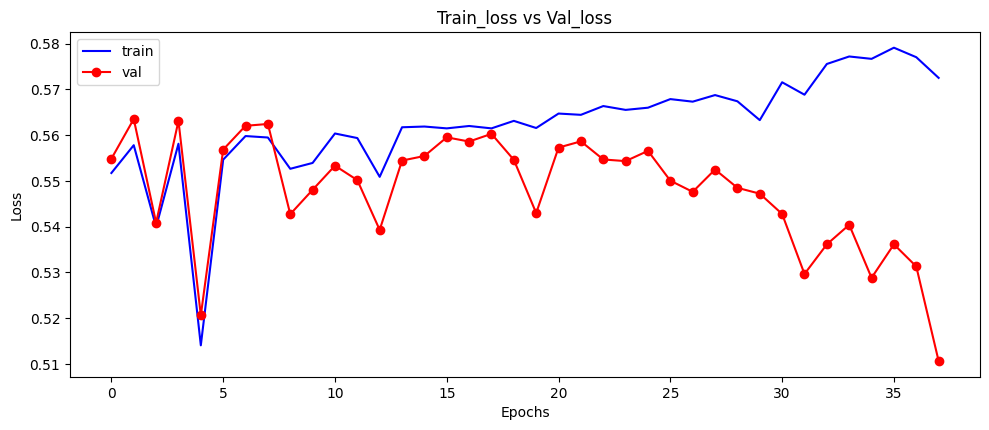

=========> Train acc: 0.573 | Test acc: 0.511


100%|██████████| 6250/6250 [02:07<00:00, 48.94it/s]


Epoch  38 | Train Loss: 15488.989973381162


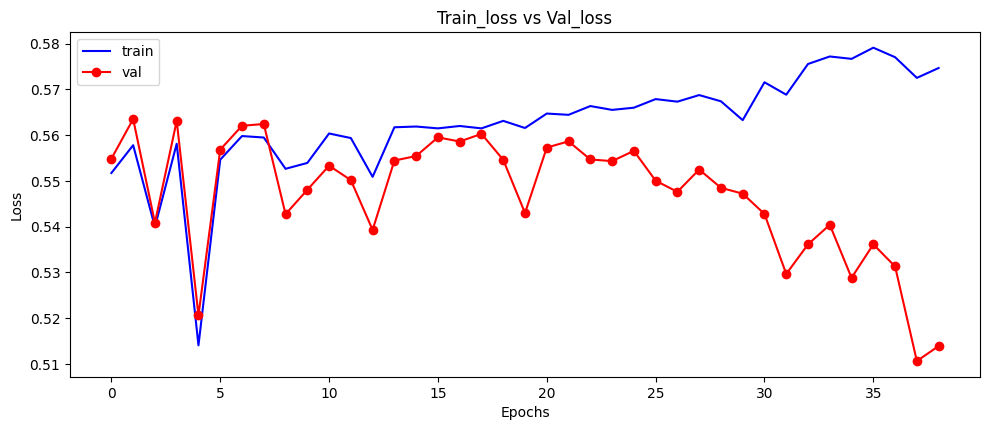

=========> Train acc: 0.575 | Test acc: 0.514


100%|██████████| 6250/6250 [02:09<00:00, 48.35it/s]


Epoch  39 | Train Loss: 15624.641442395747


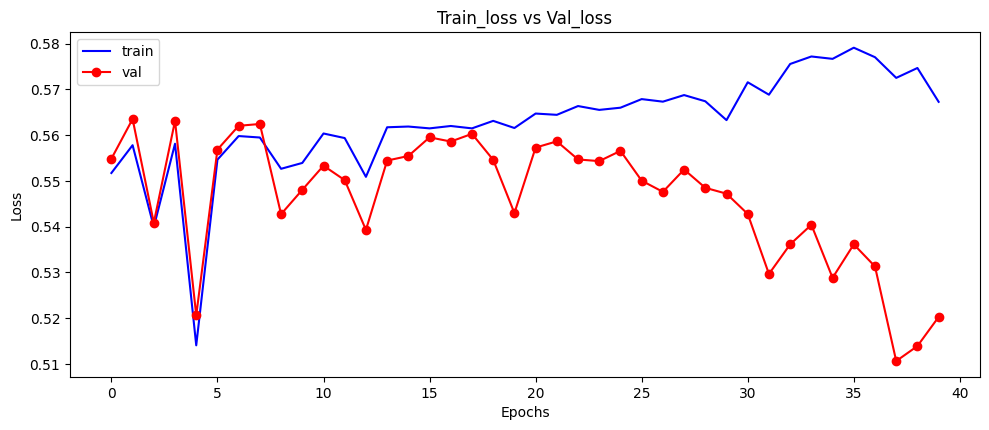

=========> Train acc: 0.567 | Test acc: 0.520


100%|██████████| 6250/6250 [02:08<00:00, 48.79it/s]


Epoch  40 | Train Loss: 15473.122058913112


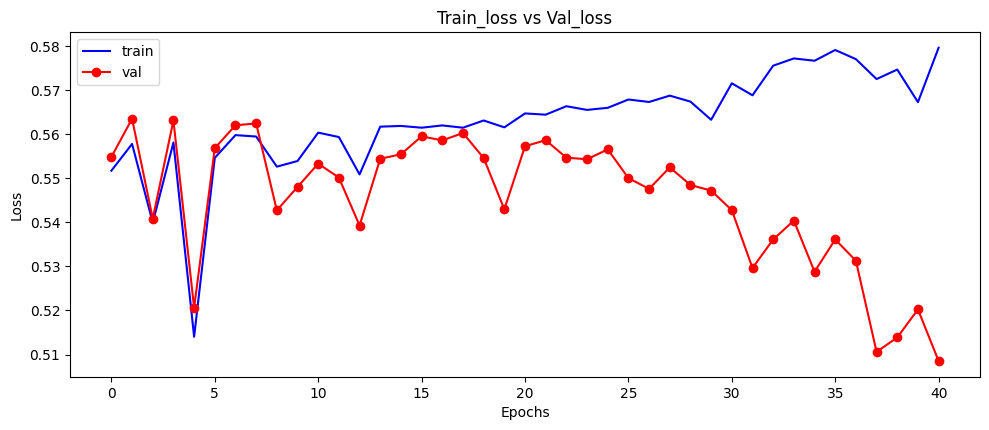

=========> Train acc: 0.580 | Test acc: 0.509


100%|██████████| 6250/6250 [02:08<00:00, 48.57it/s]


Epoch  41 | Train Loss: 15438.641478657722


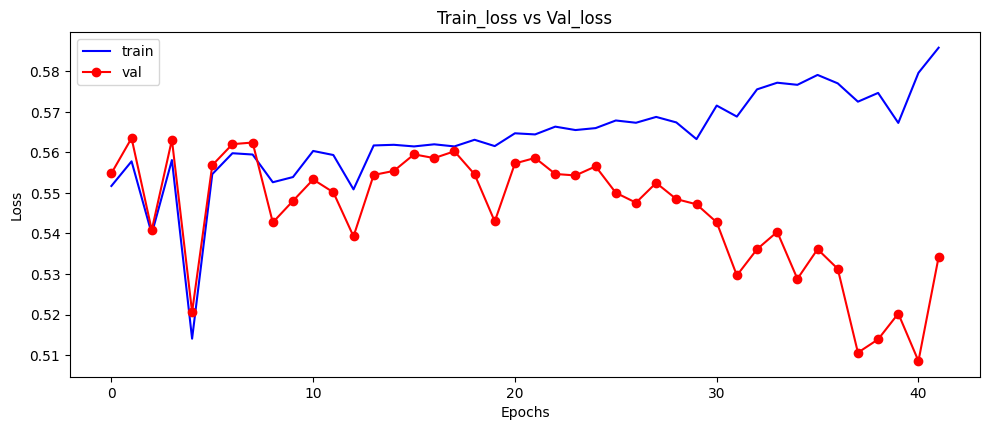

=========> Train acc: 0.586 | Test acc: 0.534


100%|██████████| 6250/6250 [02:08<00:00, 48.64it/s]


Epoch  42 | Train Loss: 15362.989175103605


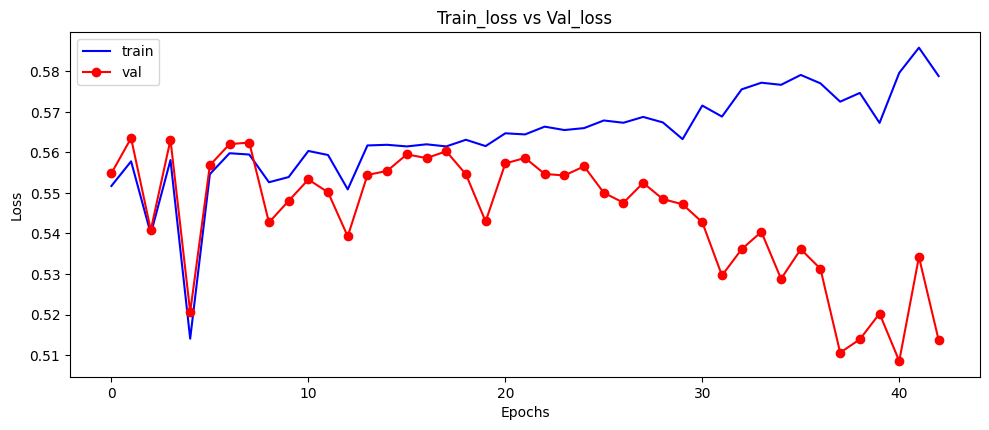

=========> Train acc: 0.579 | Test acc: 0.514


100%|██████████| 6250/6250 [02:09<00:00, 48.42it/s]


Epoch  43 | Train Loss: 15267.915431573987


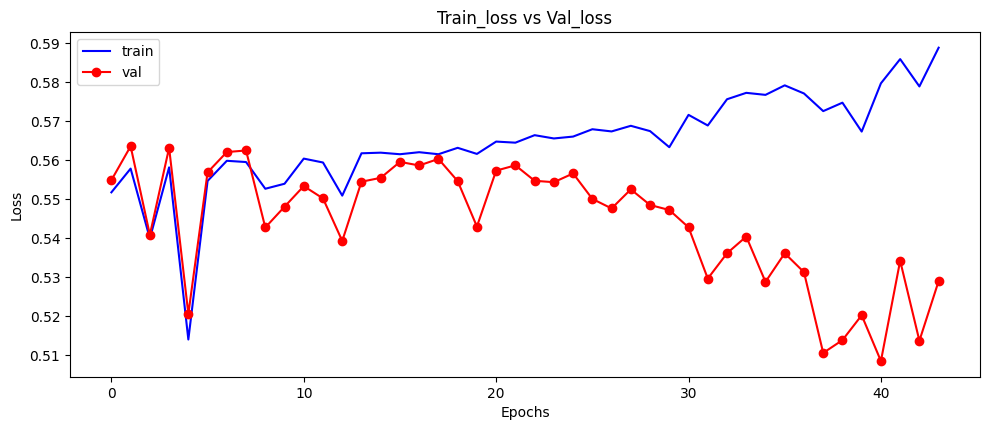

=========> Train acc: 0.589 | Test acc: 0.529


100%|██████████| 6250/6250 [02:09<00:00, 48.33it/s]


Epoch  44 | Train Loss: 15295.841977335513


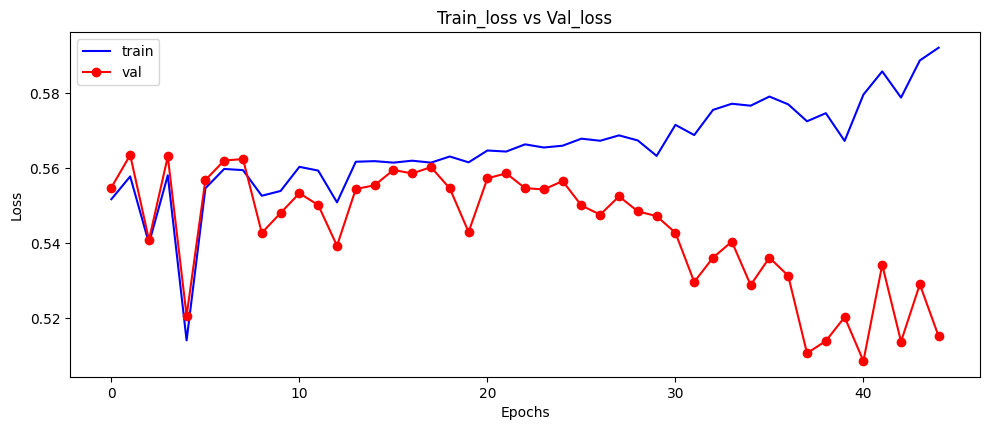

=========> Train acc: 0.592 | Test acc: 0.515


100%|██████████| 6250/6250 [02:10<00:00, 47.95it/s]


Epoch  45 | Train Loss: 15226.983853027225


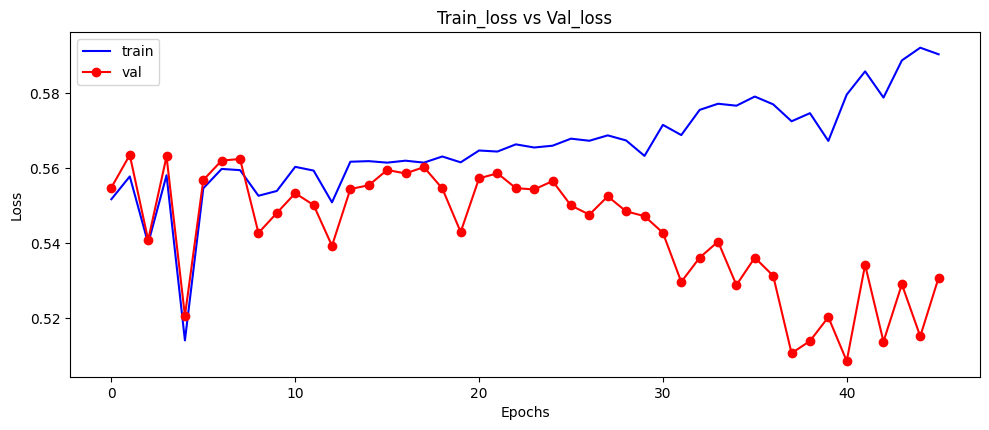

=========> Train acc: 0.590 | Test acc: 0.531


100%|██████████| 6250/6250 [02:12<00:00, 47.20it/s]


Epoch  46 | Train Loss: 15179.560214407742


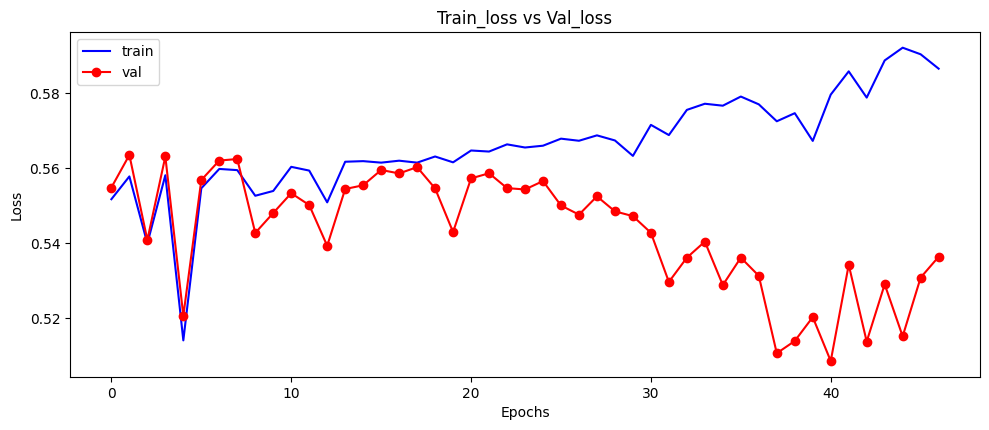

=========> Train acc: 0.587 | Test acc: 0.536


100%|██████████| 6250/6250 [02:14<00:00, 46.47it/s]


Epoch  47 | Train Loss: 15101.384639114141


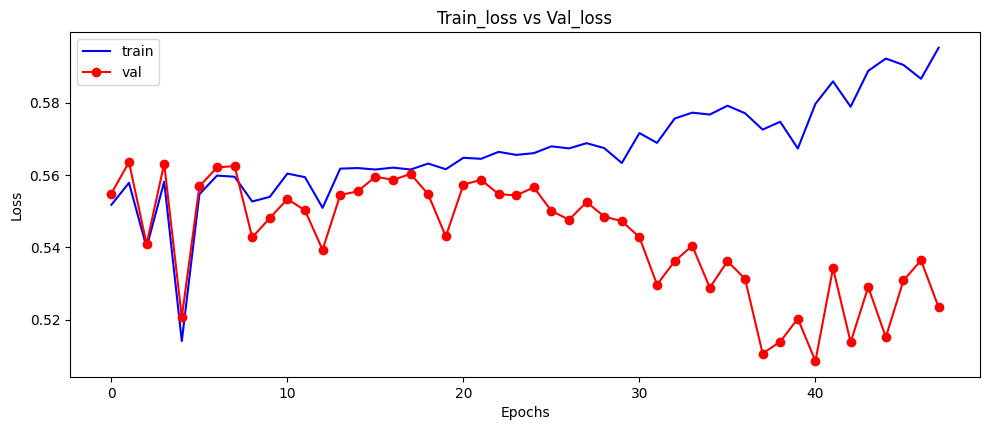

=========> Train acc: 0.595 | Test acc: 0.523


100%|██████████| 6250/6250 [02:14<00:00, 46.43it/s]


Epoch  48 | Train Loss: 15089.011709675193


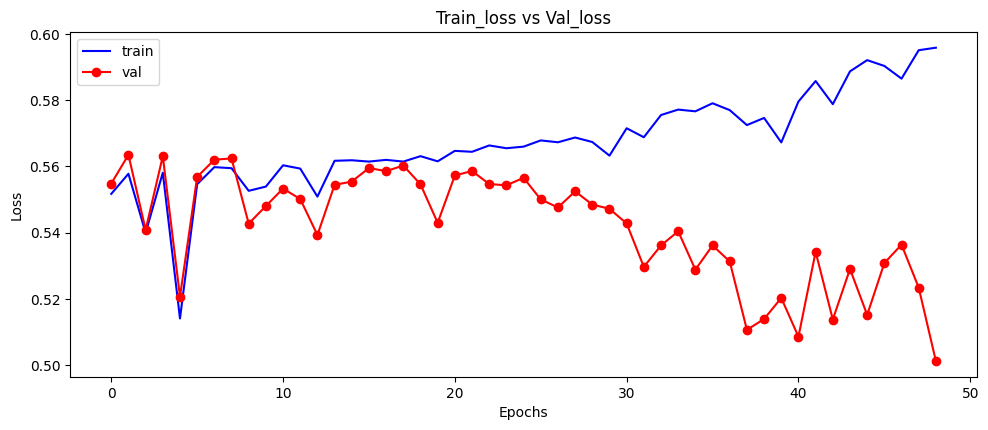

=========> Train acc: 0.596 | Test acc: 0.501


100%|██████████| 6250/6250 [02:15<00:00, 46.24it/s]


Epoch  49 | Train Loss: 15012.54316610843


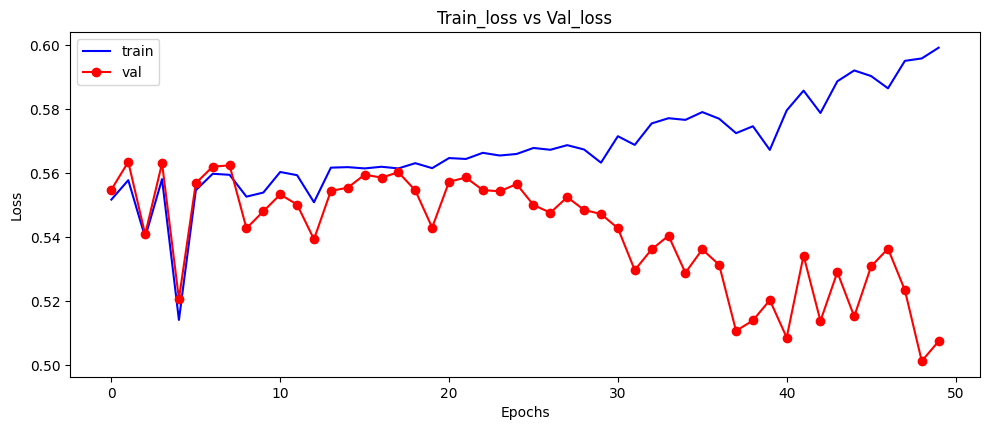

=========> Train acc: 0.599 | Test acc: 0.507


In [ ]:
from tqdm import tqdm
n_epochs = 50
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in (tqdm(train_loader)):
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).long()

    # print("Inputs shape:", inputs.shape)
    # print("Labels shape:", labels.shape)
    # print("Contains NaN in inputs:", torch.isnan(inputs).any())
    # print("Contains NaN in labels:", torch.isnan(labels).any())
    # print("Inputs range:", inputs.min().item(), inputs.max().item())

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    live_plot(train_accs,test_accs)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

[LOG] 50 epochs 결과

[MYCODE] 모델 가중치 저장


In [ ]:
print(total_loss)

print(train_accs)

nan
[0.0, 0.0]


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')